# Mid-term exam: 11 April 2023

## Topic of the exam: Pre-BREXIT analysis of Non-metallic Minerals vs. Metal Ores. 

Please ensure that you run each cell (ctrl+enter) so that your inputs are saved 

All questions have either coding cell or a text cell, or a combination of the two. 

You are allowed to create additional cells for each answer to facilitate your work  

In [1]:
# Import modules
import pandas as pd
import numpy as np

# Set pandas number format
pd.options.display.float_format = '{:,.2f}'.format

## Data preparation: Download and import exiobase

Data to be used in the exam: **year 2016 industry-by-industry format**

Link to the data: https://zenodo.org/record/5589597

#### Import Exiobase data

In [2]:
dir_path = "../data/exiobase/_ixi/IOT_2016_ixi/"

In [3]:
# Import A, Y, F and F_Y (from SATELLITE)
# ! 'A' is a large datasets, mind load time
A = pd.read_csv(f'{dir_path}A.txt', delimiter="\t", header=[0,1], index_col=[0,1])
Y = pd.read_csv(f'{dir_path}Y.txt', delimiter="\t", header=[0,1], index_col=[0,1])
# ! we use the satellite folder this time because we will look at uncharacterized stressors (CO2 emission vs GWP100)
F = pd.read_csv(f'{dir_path}satellite/F.txt', delimiter="\t", header=[0,1], index_col=[0])
F_y = pd.read_csv(f'{dir_path}satellite/F_Y.txt', delimiter="\t", header=[0,1], index_col=[0])
F_unit = pd.read_csv(f'{dir_path}satellite/unit.txt', delimiter="\t", header=0, index_col=[0])

#### Get labels

In [4]:
# get multiindex
region_and_sector_labels = A.index

# get each level using  'get_level_values()'
region_labels = A.index.get_level_values(level=0).unique()
sector_labels = A.index.get_level_values(level=1).unique()

#### Input-Output calculations
##### Leontief inverse

In [5]:
# Create an identity matrix the same order
Id = np.identity(len(region_and_sector_labels))

# Compute leontief inverse matrix in the Demand-pull model
L_values = np.linalg.inv((Id - A))
L = pd.DataFrame(
    data=L_values,
    index=region_and_sector_labels, 
    columns=region_and_sector_labels
)

# we also save LY to avoid repeating calculations
LY = L @ Y

##### Product output X

$\mathbf{x} = \mathbf{Ax} + \mathbf{Y} = \mathbf{LY}$

In [6]:
# Compute using L
x = LY.sum(axis=1)

##### Sanity check

- $\mathbf{x} = \mathbf{Z} + \mathbf{Y} = \mathbf{Z} + \mathbf{V}$  
- $\mathbf{Z} = \mathbf{A\hat{x}}$

In [7]:
# Compute x_in and x_out, using Z
Z = A * x  # = A @ np.diag(X)  --> see Practical 4
x_in = Z.sum(axis=1) + Y.sum(axis=1)

# Get X reference from Exiobase
x_exio = pd.read_csv(f'{dir_path}x.txt', delimiter="\t", header=0, index_col=[0,1])  # ! header = 0, not [0,1]

# Compare Xs
# ! x_exio is a dataframe --> take the 'indout' columns to get a pd.Series for comparison
if not np.allclose(x, x_exio['indout']):
    raise ValueError('Discrepancy with x')

if not np.allclose(x_in, x_exio['indout']):
    raise ValueError('Discrepancy with x_in')

##### Environmental intensity

In [9]:
# compute extension intensity
f = F / x.T
f = f.replace([np.inf, -np.inf, np.nan], 0)  # ! don't forget to replace

## Question 1: Territorial accounting (10 points)

### Q1.1 What was the UK's domestic extractions of non-metallic minerals in 2016? (10 points) 
Hint 1: use the environmental extensions with keywords: "Domestic Extraction Used - Non-Metallic Minerals"

Hint 2: UK's acronym is GB (i.e., Great Britain) in ISO3 

In [10]:
# Select the country of interest
country = 'GB'

# select extension indicator
MASK = f.index.str.contains("Domestic Extraction Used - Non-Metallic Minerals")
MINERALS = f.loc[MASK].index

# Display results
MINERALS

Index(['Domestic Extraction Used - Non-Metallic Minerals - Building stones',
       'Domestic Extraction Used - Non-Metallic Minerals - Chemical and fertilizer minerals',
       'Domestic Extraction Used - Non-Metallic Minerals - Clays and kaolin',
       'Domestic Extraction Used - Non-Metallic Minerals - Gravel and sand',
       'Domestic Extraction Used - Non-Metallic Minerals - Limestone, gypsum, chalk, dolomite',
       'Domestic Extraction Used - Non-Metallic Minerals - Other minerals',
       'Domestic Extraction Used - Non-Metallic Minerals - Salt',
       'Domestic Extraction Used - Non-Metallic Minerals - Slate'],
      dtype='object', name='stressor')

In [18]:
# Check that every indicator has the same unit (kt)
F_unit.loc[MINERALS]['unit'].unique()

array(['kt'], dtype=object)

In [15]:
# set variables
f_minerals = f.loc[MINERALS]
F_y_minerals = F_y.loc[MINERALS]

# Reminder
print(f_minerals.shape)
print(F_y_minerals.shape)

(8, 7987)
(8, 343)


In [27]:
# Check if F_y = 0 (for the country selected)
F_y_minerals.loc[:, country].sum()

category
Final consumption expenditure by households                                            0.00
Final consumption expenditure by non-profit organisations serving households (NPISH)   0.00
Final consumption expenditure by government                                            0.00
Gross fixed capital formation                                                          0.00
Changes in inventories                                                                 0.00
Changes in valuables                                                                   0.00
Exports: Total (fob)                                                                   0.00
dtype: float64

In [19]:
# compute domestic minerals extraction for each country (per sector)
diagfX_minerals = f_minerals * x  # f * x = np.diag(f) @ x

# Display intermediary result
print("units are in kg (instead of kt)\n")
1e6*diagfX_minerals

units are in kg (instead of kt)



region                                                                    AT  \
sector                                             Cultivation of paddy rice   
stressor                                                                       
Domestic Extraction Used - Non-Metallic Mineral...                      0.00   
Domestic Extraction Used - Non-Metallic Mineral...                      0.00   
Domestic Extraction Used - Non-Metallic Mineral...                      0.00   
Domestic Extraction Used - Non-Metallic Mineral...                      0.00   
Domestic Extraction Used - Non-Metallic Mineral...                      0.00   
Domestic Extraction Used - Non-Metallic Mineral...                      0.00   
Domestic Extraction Used - Non-Metallic Mineral...                      0.00   
Domestic Extraction Used - Non-Metallic Mineral...                      0.00   

region                                                                   \
sector                                             Cultivation of wheat   
stressor                                                                  
Domestic Extraction Used - Non-Metallic Mineral...                 0.00   
Domestic Extraction Used - Non-Metallic Mineral...                 0.00   
Domestic Extraction Used - Non-Metallic Mineral...                 0.00   
Domestic Extraction Used - Non-Metallic Mineral...                 0.00   
Domestic Extraction Used - Non-Metallic Mineral...                 0.00   
Domestic Extraction Used - Non-Metallic Mineral...                 0.00   
Domestic Extraction Used - Non-Metallic Mineral...                 0.00   
Domestic Extraction Used - Non-Metallic Mineral...                 0.00   

region                                                                               \
sector                                             Cultivation of cereal grains nec   
stressor                                                                              
Domestic Extraction Used - Non-Metallic Mineral...                             0.00   
Domestic Extraction Used - Non-Metallic Mineral...                             0.00   
Domestic Extraction Used - Non-Metallic Mineral...                             0.00   
Domestic Extraction Used - Non-Metallic Mineral...                             0.00   
Domestic Extraction Used - Non-Metallic Mineral...                             0.00   
Domestic Extraction Used - Non-Metallic Mineral...                             0.00   
Domestic Extraction Used - Non-Metallic Mineral...                             0.00   
Domestic Extraction Used - Non-Metallic Mineral...                             0.00   

region                                                                                     \
sector                                             Cultivation of vegetables, fruit, nuts   
stressor                                                                                    
Domestic Extraction Used - Non-Metallic Mineral...                                   0.00   
Domestic Extraction Used - Non-Metallic Mineral...                                   0.00   
Domestic Extraction Used - Non-Metallic Mineral...                                   0.00   
Domestic Extraction Used - Non-Metallic Mineral...                                   0.00   
Domestic Extraction Used - Non-Metallic Mineral...                                   0.00   
Domestic Extraction Used - Non-Metallic Mineral...                                   0.00   
Domestic Extraction Used - Non-Metallic Mineral...                                   0.00   
Domestic Extraction Used - Non-Metallic Mineral...                                   0.00   

region                                                                       \
sector                                             Cultivation of oil seeds   
stressor                                                                      
Domestic Extraction Used - Non-Metallic Mineral...                     0.0

In [21]:
# Display the results per stressor for the country selected (sectors are aggregated) 
diagfX_minerals.groupby('region', axis=1).sum()[country]

stressor
Domestic Extraction Used - Non-Metallic Minerals - Building stones                            0.00
Domestic Extraction Used - Non-Metallic Minerals - Chemical and fertilizer minerals         774.77
Domestic Extraction Used - Non-Metallic Minerals - Clays and kaolin                       6,151.13
Domestic Extraction Used - Non-Metallic Minerals - Gravel and sand                       59,960.55
Domestic Extraction Used - Non-Metallic Minerals - Limestone, gypsum, chalk, dolomite     9,259.08
Domestic Extraction Used - Non-Metallic Minerals - Other minerals                       122,590.38
Domestic Extraction Used - Non-Metallic Minerals - Salt                                   4,606.47
Domestic Extraction Used - Non-Metallic Minerals - Slate                                    772.30
Name: GB, dtype: float64

In [33]:
# Aggregate the results
e_pba_agg_minerals_UK = diagfX_minerals.groupby('region', axis=1).sum()[country].sum()
e_pba_agg_minerals_UK

204114.66715733145

## Question 2: Footprint analysis (10 points)

### Q2.1 What was the UK's non-metallic mineral footprint in 2016? (10 points)

In [28]:
# Compute Mineral footprint
fLY_minerals = f_minerals @ LY

e_fp_minerals = fLY_minerals + F_y_minerals  # but F_y_minerals = 0

# Display the results
e_fp_minerals

region                                                                                      AT  \
category                                           Final consumption expenditure by households   
stressor                                                                                         
Domestic Extraction Used - Non-Metallic Mineral...                                        0.44   
Domestic Extraction Used - Non-Metallic Mineral...                                      349.10   
Domestic Extraction Used - Non-Metallic Mineral...                                      125.12   
Domestic Extraction Used - Non-Metallic Mineral...                                    7,856.92   
Domestic Extraction Used - Non-Metallic Mineral...                                    1,575.08   
Domestic Extraction Used - Non-Metallic Mineral...                                   19,465.60   
Domestic Extraction Used - Non-Metallic Mineral...                                      868.47   
Domestic Extraction Used - Non-Metallic Mineral...                                        2.03   

region                                                                                                                                   \
category                                           Final consumption expenditure by non-profit organisations serving households (NPISH)   
stressor                                                                                                                                  
Domestic Extraction Used - Non-Metallic Mineral...                                               0.01                                     
Domestic Extraction Used - Non-Metallic Mineral...                                               6.07                                     
Domestic Extraction Used - Non-Metallic Mineral...                                               2.21                                     
Domestic Extraction Used - Non-Metallic Mineral...                                             266.42                                     
Domestic Extraction Used - Non-Metallic Mineral...                                              30.62                                     
Domestic Extraction Used - Non-Metallic Mineral...                                             567.55                                     
Domestic Extraction Used - Non-Metallic Mineral...                                              17.09                                     
Domestic Extraction Used - Non-Metallic Mineral...                                               0.01                                     

region                                                                                          \
category                                           Final consumption expenditure by government   
stressor                                                                                         
Domestic Extraction Used - Non-Metallic Mineral...                                        0.08   
Domestic Extraction Used - Non-Metallic Mineral...                                       75.03   
Domestic Extraction Used - Non-Metallic Mineral...                                       18.87   
Domestic Extraction Used - Non-Metallic Mineral...                                    2,452.76   
Domestic Extraction Used - Non-Metallic Mineral...                                      251.95   
Domestic Extraction Used - Non-Metallic Mineral...                                    4,717.85   
Domestic Extraction Used - Non-Metallic Mineral...                                      157.11   
Domestic Extraction Used - Non-Metallic Mineral...                                        0.13   

region                                                                            \
category                                           Gross fixed capital formation   
stressor                                                                           
Domestic Extraction Used - Non-Metallic Mineral...          

In [30]:
# Display the result for the country selected per stressor
e_fp_minerals.loc[:, country].sum(axis=1)

stressor
Domestic Extraction Used - Non-Metallic Minerals - Building stones                            8.24
Domestic Extraction Used - Non-Metallic Minerals - Chemical and fertilizer minerals       4,438.10
Domestic Extraction Used - Non-Metallic Minerals - Clays and kaolin                       4,061.75
Domestic Extraction Used - Non-Metallic Minerals - Gravel and sand                       60,528.62
Domestic Extraction Used - Non-Metallic Minerals - Limestone, gypsum, chalk, dolomite    31,956.17
Domestic Extraction Used - Non-Metallic Minerals - Other minerals                       184,237.13
Domestic Extraction Used - Non-Metallic Minerals - Salt                                   5,838.54
Domestic Extraction Used - Non-Metallic Minerals - Slate                                    389.34
dtype: float64

In [32]:
# Display the result for the country (sectors are aggregated)
e_fp_agg_minerals_UK = e_fp_minerals.loc[:, country].sum(axis=1).sum()
e_fp_agg_minerals_UK

291457.8912295183

## Questions 3: Trade (15 points)

### Q3.1: Based on Q1 & Q2, was the UK a net importer or net exporter of non-metallic minerals in 2016? (3 points)

In [37]:
e_fp_agg_minerals_UK - e_pba_agg_minerals_UK

87343.22407218683

The UK is a net imported importer of non-metallic mineral. In 2016, it imported over 87,343 kt of non-metallic minerals.

In [61]:
# ALTERNATIVE CALCULATION METHOD
f_minerals_agg = f.loc[MINERALS].sum()  # sum all minerals to have a vector (i.e. pd.Series)
diagfLY_minerals_agg = f_minerals_agg * LY.T  # = diagf @ L @ Y
diagfLY_minerals_agg = diagfLY_minerals_agg.T  # retranspose to conserve original layout

# Compute embodied mineralls in trade 
embodied_minerals_trade = diagfLY_minerals_agg.groupby('region', axis=1).sum()
embodied_minerals_trade = embodied_minerals_trade.groupby('region', axis=0).sum()
embodied_minerals_trade = embodied_minerals_trade.reindex(index=region_labels, columns=region_labels)

# Compute imported / exported emissions
exports_minerals = embodied_minerals_trade.sum(axis=1)  # add columns to get exported emissions
imports_minerals = embodied_minerals_trade.sum(axis=0)  # add rows to get imported emissions

(imports_minerals - exports_minerals)[country]

87343.2240721868

### Q3.2: Perform MRIO calculation and identify the top three regions from which the UK imported non-metallic minerals in 2016 (12 points)

In [62]:
# top countries from which the UK imports its non-metallic minerals
embodied_minerals_trade[country].nlargest(4)

region
GB   101,420.58
IN    33,566.72
CN    27,925.05
WA    20,235.46
Name: GB, dtype: float64

<Axes: ylabel='GB'>

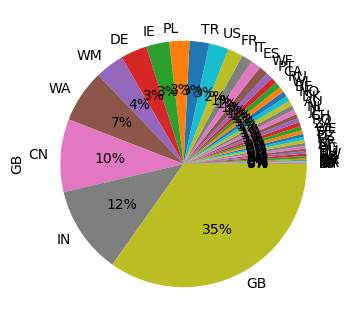

In [63]:
# show distribution of regional import of UK's need in non-metallic minerals
embodied_minerals_trade[country].sort_values().plot(
    figsize = (6,4),
    kind = 'pie',
    autopct = '%1.0f%%',
)

## Question 4: Dashboard analysis - Non-metallic Minerals vs. Metal Ores (25 points)

### Q4.1 Quantify the reliance of the UK on each of the two global regions, EU27 and Non-EU27, in 2016 concerning Non-Metallic minerals and Metal Ores. (10 points)

Hint 1: Replicate Qs 2-3 for metal ores

Hint 2: use the environmental extensions with keywords: "Domestic Extraction Used - Metal Ores"

Hint 3: remember that the first 27 regions in exiobase are the EU27

Hint 4: use the last 21 countries/regions in exiobase for Non-EU27

In [42]:
MASK = f.index.str.contains("Domestic Extraction Used - Metal Ores")
METALS = f.loc[MASK].index

# Display results
METALS

Index(['Domestic Extraction Used - Metal Ores - Bauxite and aluminium ores',
       'Domestic Extraction Used - Metal Ores - Copper ores',
       'Domestic Extraction Used - Metal Ores - Gold ores',
       'Domestic Extraction Used - Metal Ores - Iron ores',
       'Domestic Extraction Used - Metal Ores - Lead ores',
       'Domestic Extraction Used - Metal Ores - Nickel ores',
       'Domestic Extraction Used - Metal Ores - Other non-ferrous metal ores',
       'Domestic Extraction Used - Metal Ores - PGM ores',
       'Domestic Extraction Used - Metal Ores - Silver ores',
       'Domestic Extraction Used - Metal Ores - Tin ores',
       'Domestic Extraction Used - Metal Ores - Uranium and thorium ores',
       'Domestic Extraction Used - Metal Ores - Zinc ores'],
      dtype='object', name='stressor')

In [44]:
# Check that every indicator has the same unit (kt)
F_unit.loc[METALS]['unit'].unique()

array(['kt'], dtype=object)

In [51]:
# Compute intermediary variables
f_metals = f.loc[METALS]
F_y_metals = F_y.loc[METALS]

# compute domestic metal extraction for each country (per sector)
diagfX_metals = f_metals * x  # f * x = np.diag(f) @ x

# Compute domestic metals extraction fo each country (per sector)
fLY_metals = f_metals @ LY 

In [47]:
# Check if F_y = 0 (for the country selected)
F_y_metals.loc[:, country].sum()

category
Final consumption expenditure by households                                            0.00
Final consumption expenditure by non-profit organisations serving households (NPISH)   0.00
Final consumption expenditure by government                                            0.00
Gross fixed capital formation                                                          0.00
Changes in inventories                                                                 0.00
Changes in valuables                                                                   0.00
Exports: Total (fob)                                                                   0.00
dtype: float64

In [52]:
# Display the results (pba) per stressor for the country selected (sectors are aggregated) 
diagfX_metals.groupby('region', axis=1).sum()[country]

stressor
Domestic Extraction Used - Metal Ores - Bauxite and aluminium ores      0.00
Domestic Extraction Used - Metal Ores - Copper ores                     0.00
Domestic Extraction Used - Metal Ores - Gold ores                      17.64
Domestic Extraction Used - Metal Ores - Iron ores                       0.00
Domestic Extraction Used - Metal Ores - Lead ores                       0.28
Domestic Extraction Used - Metal Ores - Nickel ores                     0.00
Domestic Extraction Used - Metal Ores - Other non-ferrous metal ores    0.01
Domestic Extraction Used - Metal Ores - PGM ores                        0.00
Domestic Extraction Used - Metal Ores - Silver ores                     0.28
Domestic Extraction Used - Metal Ores - Tin ores                        0.00
Domestic Extraction Used - Metal Ores - Uranium and thorium ores        0.00
Domestic Extraction Used - Metal Ores - Zinc ores                       0.00
Name: GB, dtype: float64

In [53]:
# Aggregate the results
e_pba_agg_metals_UK = diagfX_metals.groupby('region', axis=1).sum()[country].sum()
e_pba_agg_metals_UK

18.205313967159146

In [48]:
# Compute Metals footprint
e_fp_metals = fLY_metals + F_y_metals  # but F_y_metals = 0

# Display the result for the country selected per stressor
e_fp_metals.loc[:, country].sum(axis=1)

stressor
Domestic Extraction Used - Metal Ores - Bauxite and aluminium ores      1,585.12
Domestic Extraction Used - Metal Ores - Copper ores                    15,983.78
Domestic Extraction Used - Metal Ores - Gold ores                      28,780.76
Domestic Extraction Used - Metal Ores - Iron ores                      16,989.28
Domestic Extraction Used - Metal Ores - Lead ores                         674.28
Domestic Extraction Used - Metal Ores - Nickel ores                     1,801.22
Domestic Extraction Used - Metal Ores - Other non-ferrous metal ores    1,780.71
Domestic Extraction Used - Metal Ores - PGM ores                          659.83
Domestic Extraction Used - Metal Ores - Silver ores                     6,176.78
Domestic Extraction Used - Metal Ores - Tin ores                        2,355.61
Domestic Extraction Used - Metal Ores - Uranium and thorium ores          813.74
Domestic Extraction Used - Metal Ores - Zinc ores                       2,906.19
dtype: float64

In [50]:
# Display the result for the country (sectors are aggregated)
e_fp_agg_metals_UK = e_fp_metals.loc[:, country].sum(axis=1).sum()
e_fp_agg_metals_UK

80507.28726799201

In [55]:
e_fp_agg_metals_UK - e_pba_agg_metals_UK

80489.08195402485

the UK barely extract any metals domestically, and  import almost everything (for an amount of 80,507 kt of metal ores).

In [64]:
# ALTERNATIVE CALCULATION METHOD
f_metals_agg = f.loc[METALS].sum()  # sum all metals to have a vector (i.e. pd.Series)
diagfLY_metals_agg = f_metals_agg * LY.T  # = diagf @ L @ Y
diagfLY_metals_agg = diagfLY_metals_agg.T  # retranspose to conserve original layout

# Compute embodied mineralls in trade
embodied_metals_trade = diagfLY_metals_agg.groupby('region', axis=1).sum()
embodied_metals_trade = embodied_metals_trade.groupby('region', axis=0).sum()
embodied_metals_trade = embodied_metals_trade.reindex(index=region_labels, columns=region_labels)


# Compute imported / exported emissions
exports_metals = embodied_metals_trade.sum(axis=1)  # add columns to get exported emissions
imports_metals = embodied_metals_trade.sum(axis=0)  # add rows to get imported emissions

(imports_metals - exports_metals)[country]

80489.08195402486

<Axes: ylabel='GB'>

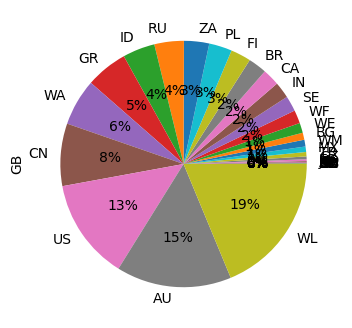

In [65]:
# show distribution of regional import of UK's need in metal ores
embodied_metals_trade[country].sort_values().plot(
    figsize = (6,4),
    kind = 'pie',
    autopct = '%1.0f%%',
)

In [108]:
# Cluster region labels together
clusters_regions = {
    'EU27' : region_labels[:27],
    'Domestic' : region_labels[27],
    'Non-EU' : region_labels[28:],
}

# Create an empty dataframe
df = pd.DataFrame(
    data=np.nan, 
    index=clusters_regions.keys(), 
    columns=['Metals', 'Minerals'])

# Fill in the dataframe
for cluster, regions in clusters_regions.items():
    df.loc[cluster, 'Metals'] = embodied_metals_trade.loc[regions, country].sum()
    df.loc[cluster, 'Minerals'] = embodied_minerals_trade.loc[regions, country].sum()

# Display results
df

,Metals,Minerals
EU27,"11,991.24","58,738.84"
Domestic,4.52,"101,420.58"
Non-EU,"68,511.53","131,298.47"


array([<Axes: ylabel='Metals'>, <Axes: ylabel='Minerals'>], dtype=object)

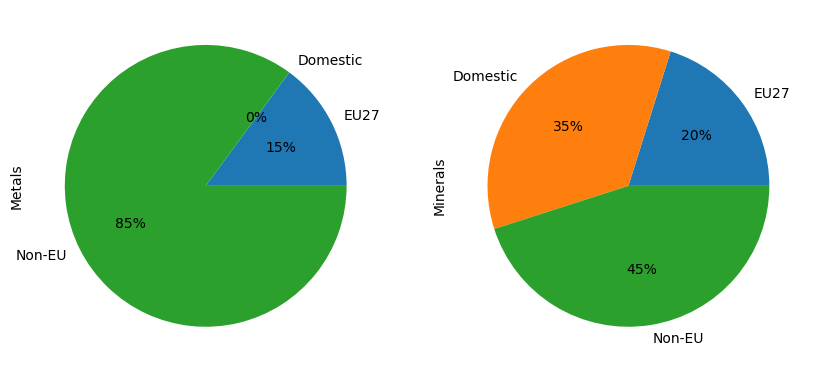

In [109]:
df.plot(
    subplots=True,
    figsize = (10,6),
    kind = 'pie',
    autopct = '%1.0f%%',
    legend=False,
)

### Q4.2 Focusing on the two types of materials, describe three significantly different findings about the UK's material reliance on the EU27 vs the rest of the world. (15 points)

The description for each finding should:

1) be supported by numerical results you obtained from above calculations and based on comparisons of numerical results; 

2) contains your reflections about the UK's trade relationship in the context of BREXIT.


In [115]:
EU = clusters_regions['EU27']

mineral_trade_with_EU = (embodied_minerals_trade.loc['GB', EU] - embodied_minerals_trade.loc[EU, 'GB']).sum()
metal_trade_with_EU = (embodied_metals_trade.loc['GB', EU] - embodied_metals_trade.loc[EU, 'GB']).sum()


print(f"Mineral trade balance with EU {int(mineral_trade_with_EU)} kt")
print(f"Metal trade balance with EU {int(metal_trade_with_EU)} kt")

Mineral trade balance with EU -14631 kt
Metal trade balance with EU -11985 kt


In [117]:
non_EU = clusters_regions['Non-EU']

mineral_trade_with_nonEU = (embodied_minerals_trade.loc['GB', non_EU] - embodied_minerals_trade.loc[non_EU, 'GB']).sum()
metal_trade_with_nonEU = (embodied_metals_trade.loc['GB', non_EU] - embodied_metals_trade.loc[non_EU, 'GB']).sum()


print(f"Mineral trade balance with non-EU {int(mineral_trade_with_nonEU)} kt")
print(f"Metal trade balance with non-EU {int(metal_trade_with_nonEU)} kt")

Mineral trade balance with non-EU -72712 kt
Metal trade balance with non-EU -68503 kt


The heavy dependence of the UK on imports of metals and minerals is evident from our analysis, with the latter being less dependent on imports due to its larger domestic production (35% vs almost 0%). An examination of the UK's footprint reveals that the country's metals requirements cannot be met domestically, and other EU member states can only partially meet this demand, accounting for just 15% of the final consumption. However, for minerals, the UK supplies about 35% of its own needs, and another 20% is fulfilled by EU partners, although reliance on non-EU countries remains high, making up 45% of the final consumption. The trade balance is negative with both EU and non-EU countries for minerals and metals. 

This analysis suggests that, in light of the Brexit situation, it may be advantageous for the UK to prioritize trade agreements with non-European countries. As a result of its exit from the EU, the UK is now responsible for its own trade negotiations with non-EU countries, which affords the country greater flexibility in its approach to trade. This independence from the EU also allows the UK to select trade barriers and tariffs that are distinct from those imposed by the EU. This also means that competitions for resource between the UK and other EU countries could also increase in the future.